In [31]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000


,Date,Open,High,Low,Close,Adj Close,Volume
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500
6515,2023-04-05,103.910004,103.910004,100.750000,101.099998,101.099998,45103000


length:6516


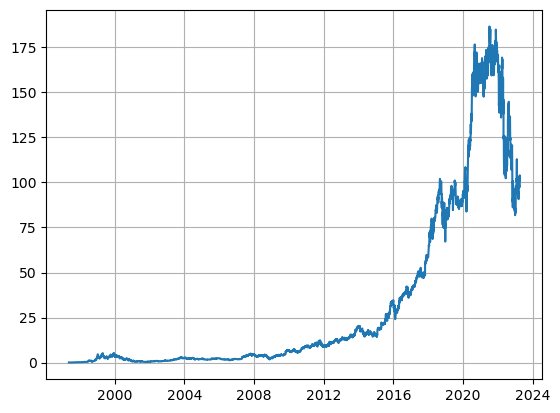

In [32]:

df = pd.read_csv('AMZN.csv')
display(df.head(3))
display(df.tail(3))
print(f'length:{len(df)}')

df = df[['Date', 'Close']]
df.Date = pd.to_datetime(df.Date)

plt.plot(df.Date, df.Close)
plt.grid()
plt.show()


In [33]:
df.shape

(6516, 2)

In [34]:
# Preparação dos Dados para LSTM
# Cada instância:
# x_i .... x_t | x_{t+1}

window_size = 5
df_copy = deepcopy(df)
df_copy.set_index('Date', inplace = True)
for t in range(1, window_size + 1)[::-1]:
    df_copy[f'Close(t-{t})'] = df_copy['Close'].shift(t)

In [39]:
df_copy.shape

(6516, 6)

In [40]:
df_copy.dropna(inplace=True)

In [41]:
df_copy.shape

(6511, 6)

In [38]:
df_copy.head(20)

,Close,Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
Date,,,,,,
1997-05-15,0.097917,NaN,NaN,NaN,NaN,NaN
1997-05-16,0.086458,NaN,NaN,NaN,NaN,0.097917
1997-05-19,0.085417,NaN,NaN,NaN,0.097917,0.086458
1997-05-20,0.081771,NaN,NaN,0.097917,0.086458,0.085417
1997-05-21,0.071354,NaN,0.097917,0.086458,0.085417,0.081771
1997-05-22,0.069792,0.097917,0.086458,0.085417,0.081771,0.071354
1997-05-23,0.075000,0.086458,0.085417,0.081771,0.071354,0.069792
1997-05-27,0.079167,0.085417,0.081771,0.071354,0.069792,0.075000
1997-05-28,0.076563,0.081771,0.071354,0.069792,0.075000,0.079167


In [4]:
df.head(10)

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
5,1997-05-22,0.069792
6,1997-05-23,0.075000
7,1997-05-27,0.079167
8,1997-05-28,0.076563
9,1997-05-29,0.075260


In [5]:
df_copy.head()

,Close,Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
Date,,,,,,
1997-05-22,0.069792,0.097917,0.086458,0.085417,0.081771,0.071354
1997-05-23,0.075000,0.086458,0.085417,0.081771,0.071354,0.069792
1997-05-27,0.079167,0.085417,0.081771,0.071354,0.069792,0.075000
1997-05-28,0.076563,0.081771,0.071354,0.069792,0.075000,0.079167
1997-05-29,0.075260,0.071354,0.069792,0.075000,0.079167,0.076563


In [6]:
data = df_copy.values

print(data.shape)

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

(6511, 6)


In [7]:
df_copy['Close'][:5]

Date
1997-05-22    0.069792
1997-05-23    0.075000
1997-05-27    0.079167
1997-05-28    0.076563
1997-05-29    0.075260
Name: Close, dtype: float64

In [8]:
df_copy['Close'].shift(1)[:5+1]

Date
1997-05-22         NaN
1997-05-23    0.069792
1997-05-27    0.075000
1997-05-28    0.079167
1997-05-29    0.076563
1997-05-30    0.075260
Name: Close, dtype: float64

In [9]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'
print(device)

cpu


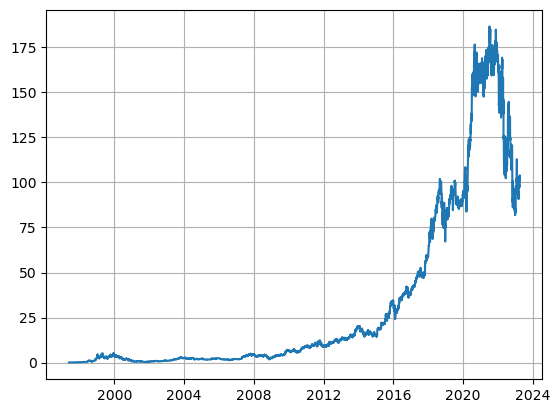

In [10]:
plt.plot(pd.to_datetime(df_copy.index), df_copy.Close)
plt.grid()
plt.show()

In [11]:
y, X = df_copy.values[:, 0], df_copy.values[:, 1:]

y.shape, X.shape 

((6511,), (6511, 5))

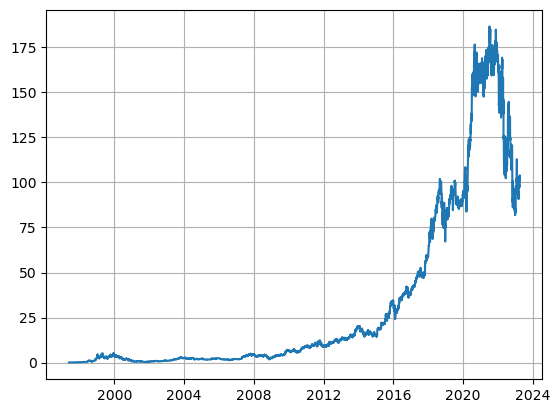

In [12]:
plt.plot(pd.to_datetime(df_copy.index), y)
plt.grid()
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5859, 5), (652, 5), (5859,), (652,))

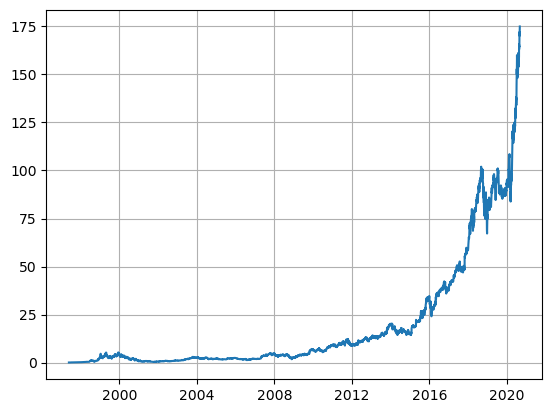

In [14]:
plt.plot(pd.to_datetime(df_copy.index[:5859]), y_train)
plt.grid()
plt.show()

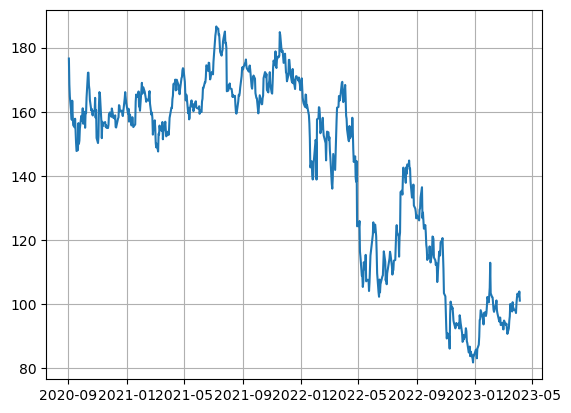

In [15]:
plt.plot(pd.to_datetime(df_copy.index[5859:]), y_test)
plt.grid()
plt.show()

In [16]:
# Inclui uma Dimensão adicional para compatibilidade com o PyTorch
X_train = X_train.reshape([-1, window_size, 1])
X_test = X_test.reshape([-1, window_size, 1])
y_train = y_train.reshape([-1, 1])
y_test = y_test.reshape([-1, 1])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5859, 5, 1), (652, 5, 1), (5859, 1), (652, 1))

In [17]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5859, 5, 1]),
 torch.Size([652, 5, 1]),
 torch.Size([5859, 1]),
 torch.Size([652, 1]))

In [18]:

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_ds = StockDataset(X_train, y_train)
test_ds = StockDataset(X_test, y_test)

In [19]:
train_loader = DataLoader(train_ds, batch_size = 16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size = 16, shuffle=False)

In [20]:
x_batch, y_batch = next(iter(train_loader))

print(x_batch.shape, y_batch.shape)

torch.Size([16, 5, 1]) torch.Size([16, 1])


In [21]:
'''
input_size: número de atributos - apenas 1 (Atributo Close)
'''

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size = 1,
            hidden_size = 32,
            num_layers = 1, 
            batch_first=True)
        self.fc = nn.Linear(32, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
model = LSTM().to(device)
model


LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [22]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm1 = nn.LSTM(input_size = 1, hidden_size = 32, num_layers = 1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size = 32, hidden_size = 16, num_layers = 1)
        self.dropout = nn.Dropout(p = 0.3)
        self.fc = nn.Linear(16, 1)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        out = self.fc(x)
        return out
    
model = LSTM().to(device)
model

LSTM(
  (lstm1): LSTM(1, 32, batch_first=True)
  (lstm2): LSTM(32, 16)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [23]:
class GRU(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.gru = nn.GRU(
            input_size = 1,
            hidden_size = 32,
            num_layers = 1, 
            batch_first=True)
        self.fc = nn.Linear(32, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
model = GRU().to(device)
model


GRU(
  (gru): GRU(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [24]:
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

out = model.forward(x_batch)
out.shape

torch.Size([16, 5, 1]) torch.Size([16, 1])


torch.Size([16, 1])

In [25]:
start = time.time()
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

avg_loss_batches_train_list = list()
avg_loss_batches_test_list = list()
for epoch in range(num_epochs):
    model.train(True)
    running_loss= 0.0
    for batch_index, (x_batch, y_batch) in enumerate(train_loader):
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    avg_loss_batches = running_loss / len(train_loader)
    avg_loss_batches_train_list.append(avg_loss_batches)
    
    model.train(False)
    running_loss= 0.0
    for batch_index, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
        
    avg_loss_batches = running_loss / len(test_loader)
    avg_loss_batches_test_list.append(avg_loss_batches)
    
    if epoch % 99 == 0:
        print('Epoch', epoch+1, 'Test Loss', avg_loss_batches_test_list[-1])
    
end = time.time()

(end-start), (end-start)/60

Epoch 1 Test Loss 16018.262778677592
Epoch 100 Test Loss 341.1874362026773


(21.82268500328064, 0.363711416721344)

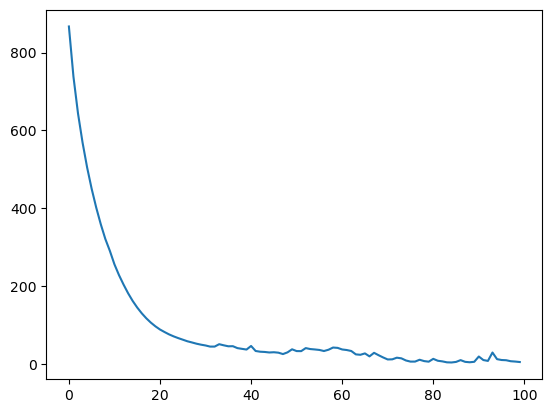

In [26]:
plt.plot(avg_loss_batches_train_list)

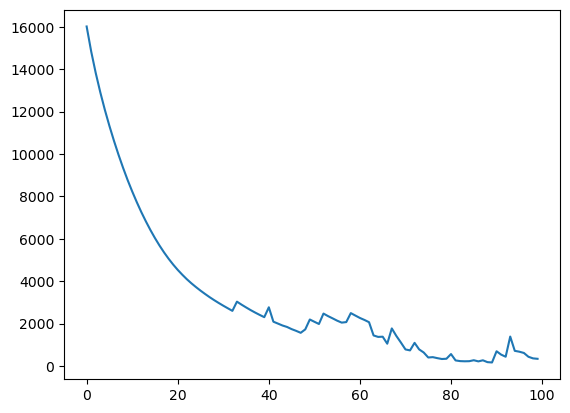

In [27]:
plt.plot(avg_loss_batches_test_list)

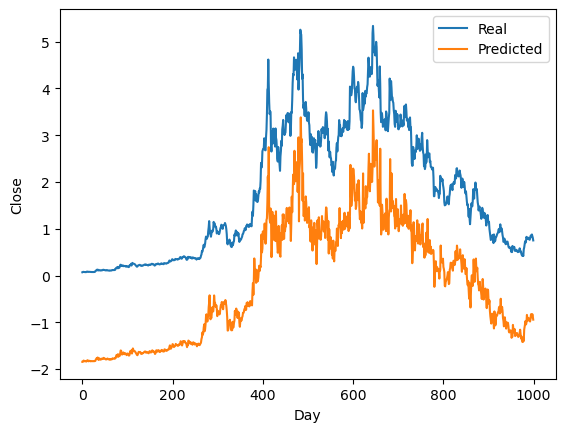

In [28]:
with torch.no_grad():
    y_predicted = model(X_train.to(device)).to('cpu').numpy()
    
plt.plot(y_train[:1000], label = 'Real')
plt.plot(y_predicted[:1000], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

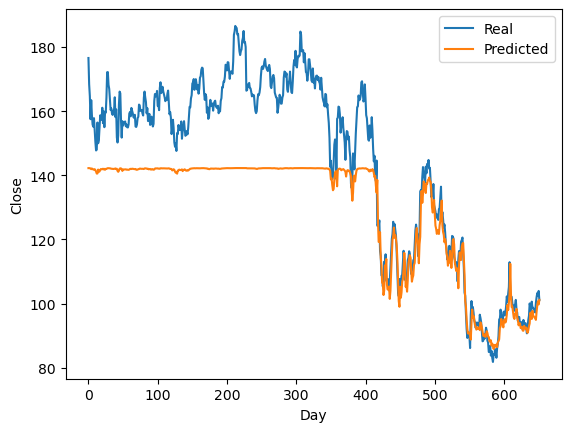

In [29]:
with torch.no_grad():
    y_predicted = model(X_test.to(device)).to('cpu').numpy()
    
plt.plot(y_test, label = 'Real')
plt.plot(y_predicted, label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

In [30]:
y_predicted.shape

(652, 1)

In [ ]:
mse_loss = nn.MSELoss()
mse = mse_loss(predictions, targets)
print("MSE:", mse.item())

In [ ]:

class CNN1DModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        # (N-F+2P)/S+1 = (5-3+2*1)/1 +1 = 5
        # 5 * 8 canais = 40
        self.fc1 = nn.Linear(40, 32) 
        self.fc2 = nn.Linear(32, 1)
 
    def forward(self, x):
        x = self.relu(self.conv1(x))
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x)) 
        x = self.fc2(x)
        
        return x


In [ ]:
model = CNN1DModel().to(device)


x, labels = next(iter(train_loader))
x = x.view(16, 1, -1)
print(x.shape)

model.forward(x)

In [ ]:
model = CNN1DModel().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

In [ ]:
print(model)

In [ ]:
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.view(inputs.size(0), 1, -1)
        y_pred = model(inputs.to(device))
        loss = loss_fn(y_pred, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 99 == 0:
        print('Epoch', epoch+1)

In [ ]:
with torch.no_grad():
    inputs = X_train.to(device)
    inputs = inputs.view(inputs.size(0), 1, -1)
    print(inputs.shape)
    y_predicted = model.forward(inputs).to('cpu').numpy()
    
plt.plot(y_train[:1000], label = 'Real')
plt.plot(y_predicted[:1000], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

In [ ]:
with torch.no_grad():
    inputs = X_test.to(device)
    inputs = inputs.view(inputs.size(0), 1, -1)
    print(inputs.shape)
    y_predicted = model.forward(inputs).to('cpu').numpy()
    
plt.plot(y_train[:1000], label = 'Real')
plt.plot(y_predicted[:1000], label = 'Predicted')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()

**Resources**
- Tutorial em vídeo: https://www.youtube.com/watch?v=q_HS4s1L8UI